# 3.7. Weight Decay

## 📘 Code Along

In [1]:
%matplotlib inline
import torch
from torch import nn

### 3.7.1. Norms and Weight Decay

### 3.7.2. High-Dimensional Linear Regression

In [8]:
import sys
sys.path.append("../..")

from utils import DataModule
from utils import Trainer
from models import LinearRegressionScratch

In [4]:
class Data(DataModule):
    def __init__(self, num_train, num_val, num_inputs, batch_size):
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = torch.randn(n, num_inputs)
        noise = torch.randn(n, 1) * 0.01
        w, b = torch.ones((num_inputs, 1)) * 0.01, 0.05
        self.y = torch.matmul(self.X, w) + b + noise

    def get_dataloader(self, train):
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader([self.X, self.y], train, i)

### 3.7.3. Implementation from Scratch

In [5]:
def l2_penalty(w):
    return (w ** 2).sum() / 2

In [7]:
class WeightDecayScratch(LinearRegressionScratch):
    def __init__(self, num_inputs, lambd, lr, sigma=0.01):
        super().__init__(num_inputs, lr, sigma)
        self.save_hyperparameters()

    def loss(self, y_hat, y):
        return (super().loss(y_hat, y) +
                self.lambd * l2_penalty(self.w))

In [9]:
data = Data(num_train=20, num_val=100, num_inputs=200, batch_size=5)
trainer = Trainer(max_epochs=10)

def train_scratch(lambd):
    model = WeightDecayScratch(num_inputs=200, lambd=lambd, lr=0.01)
    model.board.yscale='log'
    trainer.fit(model, data)
    print('L2 norm of w:', float(l2_penalty(model.w)))

L2 norm of w: 0.008650004863739014


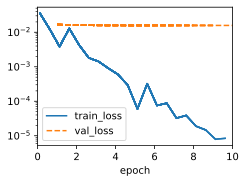

In [10]:
train_scratch(0)

L2 norm of w: 0.0014457976212725043


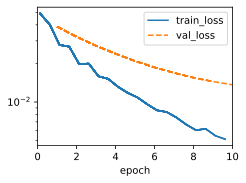

In [11]:
train_scratch(3)

### 3.7.4. Concise Implementation

In [14]:
from models import LinearRegression

In [15]:
class WeightDecay(LinearRegression):
    def __init__(self, wd, lr):
        super().__init__(lr)
        self.save_hyperparameters()
        self.wd = wd

    def configure_optimizers(self):
        return torch.optim.SGD([
            {'params': self.net.weight, 'weight_decay': self.wd},
            {'params': self.net.bias}], lr=self.lr)

L2 norm of w: 0.012825879268348217


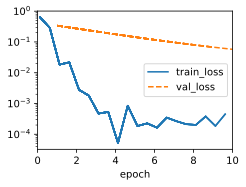

In [16]:
model = WeightDecay(wd=3, lr=0.01)
model.board.yscale='log'
trainer.fit(model, data)

print('L2 norm of w:', float(l2_penalty(model.get_w_b()[0])))